# 基本

In [1]:
import pandas as pd
import time
from tqdm.notebook import tqdm
import pickle
import re 
from urllib.request import urlopen
import numpy as np
import requests
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import permutations
import warnings
warnings.simplefilter(action="ignore")

import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb_o

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

In [2]:
results_19 = pd.read_pickle('results_19.pickle')
results_20 = pd.read_pickle('results_20.pickle')
results_21 = pd.read_pickle('results_21.pickle')
results_all = pd.read_pickle('results_all.pickle')
results_all.drop(["cource_len","data"], axis=1, inplace=True)

horse_results = pd.read_pickle('horse_results_19.pickle')
horse_results_20 = pd.read_pickle('horse_results_20.pickle')
horse_results_21 = pd.read_pickle('horse_results_21.pickle')
horse_results_all = 

peds = pd.read_pickle('peds-Copy1.pickle')
peds_all = pd.read_pickle('peds_all.pickle')
n_peds_all = pd.read_pickle('n_peds_all')
n_peds_all2 = pd.read_pickle('n_peds_all2.pickle')

#r.data_cの馬番をsortしたもの　リークをなくすため
r_data_sort = pd.read_pickle("r_data_sort.pickle")

return_tables_19 = pd.read_pickle('Return_tables_19.pickle')
return_tables_20 = pd.read_pickle('Return_tables_20.pickle')
return_tables_21 = pd.read_pickle('Return_tables_21.pickle')
return_tables_all = pd.read_pickle("Return_tables_all.pickle")

# 関数

In [3]:
#min_thresholdの値から1までを100等分する
def gain(return_func, X, n_samples=100, range_=[0.5, 3.5]):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = range_[1] * i / n_samples + range_[0] * (1 - (i / n_samples))
        n_bets, return_rate, n_hits, std = return_func(X, threshold)
        if n_bets > 2:
            gain[threshold] = {"return_rate":return_rate,
                                "n_hits":n_hits,
                                "std":std,
                                "n_bets":n_bets}
    return pd.DataFrame(gain).T

# yearに値を入れればいい
def race_id_c(year):
    race_id_list = []
    
    race_id_head = year
    for place in range(1,11,1):
        for kai in range(1,6,1):
            for day in range(1,13,1):
                for r in range(1,13,1):
                    race_id = str(place).zfill(2) + str(kai).zfill(2) +\
                    str(day).zfill(2) + str(r).zfill(2)
                    race_ids = race_id_head + race_id
                    race_id_list.append(race_ids)
    return race_id_list

def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

def plot(df, label=' '):
    plt.fill_between(df.index, y1=df['return_rate']-df['std'],
        y2=df['return_rate']+df['std'],alpha=0.3)
 
    plt.plot(df.index, df['return_rate'], label=label)
    plt.legend()
    plt.grid(True)

place_dict = {
    '札幌':'01',  '函館':'02',  '福島':'03',  '新潟':'04',  '東京':'05', 
    '中山':'06',  '中京':'07',  '京都':'08',  '阪神':'09',  '小倉':'10'
}

race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

# Dataprocessor

In [4]:
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame() # raw data
        self.data_p = pd.DataFrame() #after preprocessing
        self.data_h = pd.DataFrame() #after merging horse_results
        self.data_pe = pd.DataFrame() #after merging peds
        self.data_c = pd.DataFrame() #after processing categorical features
        self.data_ = pd.DataFrame()
        #self.no_peds #親データがないhorse_id_list
    
    # 馬の過去成績のデータ追加    
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
            
        #self.data_h["interval"] = (self.data_h["data"] - self.data_h["latest"]).dt.days
        self.data_h.drop(["開催"],axis=1, inplace=True)
    
    # 馬の親データの追加                
    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(peds,left_on='horse_id',
        right_index=True, how='left')
        
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]\
            ['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds"')
    
    # 質的変数への変換        
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        #ラベルエンコーディング　horse_id,jockey_idを0始まりの整数に変換
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        df["horse_id"] = df["horse_id"].astype('category')
        df["jockey_id"] = df["jockey_id"].astype('category')
        
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        #race_idを軸に馬番をsort
        df = df.reset_index().sort_values(["index","馬番"]).set_index('index')
        df.index.name = None
        
        self.data_c = df
     
    
# Results class 
# 足りないhorse_idをスクレイプした際は確認したのちdef to_data_frameを使う必要あり
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
    
    # path_listはpickle名
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list, pre_race_results={}):
        race_results = pre_race_results
        for race_id in tqdm(race_id_list):
            if race_id in race_results.key():
                continue
            
            try:
                time.sleep(1)
                url = "https://db.netkeiba.com/race/" + race_id
                df = pd.read_html(url)[0]
                html = requests.get(url)
                html.encode = "EUC-JP"
                soup = BeautifulSoup(html.text, "html.parser")
                
                texts = (
                    soup.find("div", attrs={"class" : "data_intro"}).find_all("p")[0].tesxt
                    + soup.find("div", attrs={"class" : "data_intro"}).find_all("p")[1].tesxt
                )
                info = re.findall(r"\w+", texts)
                for text in info:
                    if text in ["芝", "ダート"]:
                        df["race_type"] = [text] * len(df)
                    if "障" in text:
                        df["race_type"] = ["障害"] * len(df)
                    if "m" in text:
                        df["course_len"] = [int(re.findall(r"\d+", text)[0])] * len(df)
                    if text in ["良", "稍重", "稍", "重", "不良"]:
                        df["ground_state"] = [text] * len(df)
                    if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                        df["weather"] = [text] * len(df)
                    if "年" in text:
                        df["date"] = [text] * len(df)
                        
                #馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/horse")}
                )
                for a in horse_a_list:
                    horse_id = re.findall(r"\d+", a["href"])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/jockey")}
                )
                for a in jockey_a_list:
                    jockey_id = re.findall(r"\d+", a["href"])
                    jockey_id_list.append(jockey_id[0])
                df["horse_id"] = horse_id_list
                df["jockey_id"] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)
                
                race_results[race_id] = df 
                
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        return race_results
        # 一度dataframe型に直さずに出力を返す        
        #return race_results
        
    def to_data_frame(race_results):
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
        
        
        
    # to_dataframe関数で出力後にdataframe型に変換が可能            
    #def to_dataframe(race_results):
        #race_results_df = pd.concat([race_results[key] for key in race_results])
        
        #r.data_rr = race_results_df                    
                
    # regressionをtrueにすることでsecond,着順が表示され回帰が行える。
    def preprocessing(self, regression=False):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける (馬体重修正するかも)
        df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
        df["体重変化"] = df["馬体重"]\
            .str.split("(", expand=True)[1].replace("前計不", "0").str[:-1].astype(dtype = int)

        # データをint, floatに変換
        df["単勝"] = df["単勝"].astype(float)
        df['course_len'] = df['course_len'].astype(float) // 100

        # 不要な列を削除
        #回帰子を作るために一時的に着順,タイムの列を削除しない。
        #df.drop(["タイム", "着差", "調教師", "性齢", "馬体重","馬名","騎手","人気","着順"], axis=1, inplace=True)
        df.drop(["着差", "調教師", "性齢", "馬体重","馬名","騎手","人気"], axis=1, inplace=True)

        df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")
        
        df["タイム"].fillna("0", inplace=True)
        df["a"] = df["タイム"].map(lambda x:re.sub(r"\D", "", x)).astype(str)
        df["second"] = df["a"].map(lambda x: 0 if x=="0" \
        else (int(x[0]) * 60) + int(x[1:3]) + int(x[1:])/10).astype(float)
        df.drop("a", axis=1 ,inplace=True)
        df.drop(["タイム"],axis=1, inplace=True)
        
        df["rls"] = df["second"]\
        .map(lambda x: np.sqrt(np.log(x)))
        
        df['開催'] = df.index.map(lambda x: str(x)[4:6])
        
        df["n_horses"] = df.index.map(df.index.value_counts())
        
        if regression == True:
            self.data_p = df
        else:
            self.data_p = df.drop(["second","着順","rls"],axis=1)
    
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)
  
    
# ShutubaTable class        
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
        
    @classmethod    
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T
            
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")
            
            texts = soup.find("div", attrs={"class":"RaceData01"}).text
            texts = re.findall(r"\w+", texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df["weather"] = [text] * len(df)
                if text in ["良", "稍重", "稍", "重"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)
            
            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            data = data.append(df)
            time.sleep(1)
        return cls(data)

    #disclosuer = Trueで馬体重が公開されていないデータでも予測が行える        
    def preprocessing(self, disclosuer=False):
        df = self.data.copy()
        
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        if disclosuer == True:
            df["体重"] = 470
            df["体重変化"] = 0
        else:
            df = df[df["馬体重(増減)"] != '--']
            df["体重"] = df["馬体重(増減)"].str.split("(", expand=True)[0].astype(int)

            df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1].replace("前計不)", "0)").str[:-1].astype(dtype = int)
            
        
        #df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1]
        #df["体重変化"] = df["体重変化"].replace("前計不)", "0)")
        #df["体重変化"] = df["体重変化"].str[:-1].astype(int)
        
        df["date"] = pd.to_datetime(df["date"])
        
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)
        
        df["開催"] = df.index.map(lambda x:str(x)[4:6])
        
        df["n_horses"] = df.index.map(df.index.value_counts())

        # 不要な列を削除
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather','race_type',
        'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢',
        '体重', '体重変化',"開催","n_horses"]]
        
        self.data_p = df.rename(columns={'枠': '枠番'})
        

# Return

In [5]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    # path_listはpathではなく保存名で良い
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
                #そのため、改行コードを文字列brに変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')
                dfs = pd.read_html(html)

                #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
                df = pd.concat([dfs[1], dfs[2]])

                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(0.7)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        return return_tables_df
    
    @property
    def sanrenpuku(self):
        sanrenpuku = self.return_tables[self.return_tables[0] == "三連複"][[1,2]]
        wins = sanrenpuku[1].str.split('-', expand=True)[[0,1,2]].add_prefix('wins_')
        return_ = sanrenpuku[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x:pd.to_numeric(x.str.replace(',',''), errors='coerce'))
    
    @property
    def sanrentan(self):
        sanrentan = self.return_tables[self.return_tables[0] == "三連単"][[1,2]]
        wins = sanrentan[1].str.split('→', expand=True)[[0,1,2]].add_prefix('wins_')
        return_ = sanrentan[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce'))
    
    @property #本来ならRetrun(return_tables).fukusho(retrun_tables)の形だが、
    #Retrun(return_tables).fukushoで扱える
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        wins.columns = ['win_0','win_1','win_2']
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0','return_1','return_2']
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', "")
        return df.fillna(0).astype(int)
        
    
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0] == "ワイド"][[1,2]]
        wins = wide[1].str.split('br', expand=True)[[0,1,2]]
        wins = wins.stack().str.split('-', expand=True).add_prefix('win_')
        return_ = wide[2].str.split('br', expand=True)[[0,1,2]]
        return_ = return_.stack().rename("return")
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x.str.replace(",",""),errors='coerce'))
    
    @property #単勝に対して予測を行う
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1,2]]
        tansho.columns = ['win','return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == "馬連"][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]].add_prefix("win_")
        #wins.columns = (["win_1","win_2"])#.add_prefix("win_")
        return_ = umaren[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
    
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0] == '馬単'][[1,2]]
        wins = umatan[1].str.split("→", expand=True)[[0,1]].add_prefix("win_")
        return_ = umatan[2].rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
        
        #for column in umaren.columns:
            #umaren[column] = pd.to_numeric(umaren[column], errors='coerce')

# ModelEvaluator

In [7]:
#このクラス内において、第一引数にあたるxにはX_testのようなテストデータを入れる(単勝項目があるもの)
# return_tables_path = pickle_path
class ModelEvaluator:
    
    def __init__(self, model, return_tables_list):
        self.model = model
        self.rt = Return.read_pickle(return_tables_list)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.umatan = self.rt.umatan
        self.wide = self.rt.wide
        self.sanrentan = self.rt.sanrentan
        self.sanrenpuku = self.rt.sanrenpuku
        #self.std = std

    #3着以内に入る確率を予測、表示
    #X = Objective Variable type
    #引数train 項目に"単勝"があればdropする
    #引数std 標準偏差の計算を行う
    #引数minmax 出力された値のスケーリングを行う
    def predict_proba(self, X, train=True, std=True, minmax=False):
        #相対評価工程
        if train:
            proba = pd.Series(self.model.predict_proba(X.drop(["単勝"], axis=1))[:,1], index=X.index)
        else:
            proba = pd.Series(self.model.predict_proba(X, axis=1)[:,1], index=X.index)
        #proba = pd.Series(self.model.predict_proba(X)[:,1], index=X.index)
        if std:
            standerd_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standerd_scaler)
            
        #min-maxスケーリング
        if minmax:
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba 
    
    #閾値(threshold)を設定する　デフォルト0.6
    #predict_probaで確率がthreshold以上であれば1を出力(1=賭ける)
    def predict(self, X, threshold=0.6):
        y_pred = self.predict_proba(X)
        self.proba = y_pred
        return [0 if p<threshold else 1 for p in y_pred]
        
    #auc曲線のスコアを求める
    def roc_auc_score(self, y_test, X_test):
        return roc_auc_score(y_test, lgb_clf.predict_proba(X_test.drop(["単勝"], axis=1))[:, 1])
    
    #各成分の特徴量の強さの表示 デフォルト20
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features":X.columns, 
                                  "importance":self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    #閾値を通して1と判定されたものだけをpred_tableとして出力する
    def pred_table(self, X, threshold=0.6, bet_only = True):
        pred_table = X.copy()[['馬番',"単勝"]]
        pred_table['pred'] = self.predict(X, threshold)
        pred_table["score"] = self.proba
        return pred_table[pred_table["pred"] == 1]
  
    # umabanはint型で入力する必要がある
    def bet(self, race_id, kind, umaban, amount):
        if kind == "tansho":
            rt_a = self.tansho.loc[race_id]
            return_ = (rt_a['win'] == umaban) * amount/100 * rt_a['return']
        elif kind == "fukusho":
            rt_a = self.fukusho.loc[race_id]
            return_ = ((rt_a[["win_0","win_1","win_2"]] == umaban).values * \
            rt_a[['return_0',"return_1","return_2"]]).sum() * amount/100
        elif kind == "umaren":
            rt_a = self.umaren.loc[race_id]
            return_ = (set(rt_a[["win_0","win_1"]]) == set(umaban)) * rt_a["return"] *\
            amount/100
        elif kind == "umatan":
            rt_a = self.umatan.loc[race_id]
            return_ = (list(rt_a[["win_0","win_1"]]) == list(umaban)) * rt_a["return"] *\
            amount/100
        elif kind == "wide":
            rt_a = self.wide.loc[race_id]
            return_ = (rt_a[["win_0","win_1"]].apply(lambda x:set(x)==set(umaban),axis=1)) *\
            rt_a["return"] / 100 * amount
        elif kind == "sanrentan":
            rt_a = self.sanrentan.loc[race_id]
            return_ = (list(rt_a[["wins_0","wins_1","wins_2"]])==list(umaban))*\
            rt_a["return"] / 100 * amount 
        elif kind == 'sanrenpuku':
            rt_a = self.sanrenpuku.loc[race_id]
            return_ = (set(rt_a[["wins_0","wins_1","wins_2"]])==set(umaban))*\
            rt_a["return"]/100 * amount
        elif not (return_ >= 0):
            return_ = amount
        return return_
                

    #items=True　にすることで、項目名の確認が可能になる。
    #ただし、Trueの状態では、gain関数に利用することができないのでFalseの必要がある  
    def fukusho_return(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([\
                self.bet(race_id,"fukusho",umaban,1) for umaban in preds["馬番"]\
                                      ]))
        return_rate = np.sum(return_list) / n_bets
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        
        if items == True:    
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
    
    def tansho_return(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        self.sample = pred_table
        n_bets = len(pred_table)
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum([self.bet(race_id,"tansho",umaban,1) for umaban in preds["馬番"]])
            )
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std     
 
    def tansho_return_proper(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum(preds.apply(lambda x:self.bet(
                race_id, "tansho", x["馬番"], 1/x["単勝"]), axis=1)))
        bet_money = (1 / pred_table["単勝"]).sum()
        std = np.std(return_list) * np.sqrt(len(return_list)) / bet_money
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / bet_money
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std

    
    def umaren_box(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        return_list = []
        
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "umaren", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
                
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:    
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std

    
    def umatan_box(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold, bet_only=False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "umatan", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
            
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets            
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std

        
    def wide_box(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold, bet_only=False)
        n_bets = 0
            
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(presd_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "wide", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
                    
        std = np.sum(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
            
    def sanrentan_box(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
            
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(prefs) < 3:
                continue
            else:
                for umaban in permutations(preds["馬番"], 3):
                    return_ += self.bet(race_id, "sanrentan", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
                
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
            
    def sanrenpuku_box(self, X, threshold=0.6, items=False):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        return_list = []
            
        for race_id, preds in pred_table.groupbu(level=0):
            return_ = 0
            if len(preds) < 3:
                continue
            else:
                for umaban in combinations(preds["馬番"], 3):
                    return_ += self.bet(race_id ,"sanrenpuku", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
        
    def umaren_nagashi(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold, bet_only=False)
        n_bets = 0
        return_lsit = []
            
        for race_id, preds in pred_table.groupbu(level=0):
            return_ = 0
            preds_ijku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values("score", ascending=False)\
                .iloc[1:(n_aite+1)]["馬番"]
                return_ = preds_aite.map(
                race_id, "umaban", [preds_jiku["馬番"].values[0], x], 1).sum()
                n_bets += n_aite
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "umaban", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])    
        return_rate = np.sum(return_list) / n_bets 
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
        
    def umatan_nagashi(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshold, bet_only=False)
        n_bets = 0
        return_lsit = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values("score", ascending=False).\
                iloc[1: (n_aite+1)]["馬番"]
                return_ = preds_aite.map(
                lambda x: self.bet(race_id, "umatan", [preds_jiku["馬番"].values[0], x], 1)).sum()
                n_bets += n_aite
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "umatan", umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
        
    def wide_nagashi(self, X, threshold=0.6, n_aite=5, items=False):
        pred_table = self.pred_table(X, threshpld, bet_only=False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values("scoer", ascending=False).iloc[1:(n_aite+1)]["馬番"]
                return_ = preds_aite.map(lambda x: self.bet(race_id, "wide", [preds_jiku["馬番"].values[0], x], 1)).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku["馬番"], 2):
                    return_ += self.bet(race_id, "wide", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
        
    def sanrentan_nagshi(self, X, thresholf=1.5, n_aite=7, items=False):
        pred_table = self.pred_table(X, thresholod, bet_only=False)
        n_bets = 0
        return_ = []
        for race_id, preds in pred_table.groupbu(level=0):
            preds_jiku = preds.query("pred == 1")
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) == 2:
                preds_aite = preds.sort_values("score", ascending=False).\
                iloc[2: (n_aite+2)]["馬番"]
                return_ = preds_aite.map(lambda x: self.bet(race_id, "sanrentan",np.append\
                                                                (preds_jiku["馬番"].values, x), 1)).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 3:
                return_ = 0
                for umaban in permutations(preds_jiku["馬番"], 3):
                    return_ += self.bet(race_id, "sanrentan", umaban, 1)
                    n_bets += 1
                return_list.append(return_)
                
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_lsit) / n_bets
        if items == True:
            return {"n_bets":n_bets, "return_rate":return_rate, "n_hits":n_hits, "std":std}
        else:
            return n_bets, return_rate, n_hits, std
            

# Horse_Results

In [8]:
class Horse_Results:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','着順','賞金','着差','通過','開催','距離']]
        self.preprocessing()
        #self.horse_results.rename(columns={'着順':'着順_ave','賞金':'賞金_ave'}, inplace=True)
    
    # path_listはHorse_Results.pickle名
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    # 使い方
    # Horse_Results.read_pickle([pickle名])
    
    @staticmethod
    def scrape(horse_id_list):
        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
        
        
    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        #賞金のNaNを0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        #1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x<0 else x)
        
        #レース展開データ
        #n=1: 最初のコーナー位置, n=4: 最終コーナー位置
        def corner(x, n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        
        #開催場所
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        #race_type
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        #距離
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) // 100
        df.drop(['距離'], axis=1, inplace=True)
        
        #インデックス名を与える
        df.index.name = 'horse_id'
    
        self.horse_results = df
        self.target_list = ['着順', '賞金', '着差', 'first_corner',
                            'first_to_rank', 'first_to_final','final_to_rank']
        
        
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.loc[horse_id_list]
        
        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
          
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list]\
            .mean().add_suffix('_{}R'.format(n_samples))
        for column in ['course_len', 'race_type', '開催']:
            self.average_dict[column] = filtered_df.groupby(['horse_id', column])\
                [self.target_list].mean().add_suffix('_{}_{}R'.format(column, n_samples))    
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id',
                             right_index=True, how='left')
        for column in ['course_len','race_type', '開催']:
            merged_df = merged_df.merge(self.average_dict[column], 
                                        left_on=['horse_id', column],
                                        right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat(
            [self.merge(results, date, n_samples) for date in tqdm(date_list)]
        )
        return merged_df
    
   

# Peds

In [10]:
class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_e = pd.DataFrame() #after label encoding and transforming into category
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')
    
    # Peds.read_pickle(["pickle_path"])
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
        #df = pd.concat([pd.read_pickle(path) for path in path_list])
        #return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = "https://db.netkeiba.com/horse/ped/" + horse_id
                df = pd.read_html(url)[0]
                
                #重複を削除して1列のSeries型データに直す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis = 1, inplace = True)
                    df = df.drop_duplicates()
                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
                
                peds_dict[horse_id] = ped.reset_index(drop = True)
                time.sleep(0.7)
                
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        #return peds
                
        #列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')
    
        return peds_df

# classifier

In [419]:
r = Results(results_all)
r.preprocessing()
hr = Horse_Results.read_pickle(["horse_results_19.pickle",
                   'horse_results_20.pickle',
                   'horse_results_21.pickle'])
r.merge_horse_results(hr)
P = Peds(n_peds_all2)
P.encode()
r.merge_peds(P.peds_e)
r.process_categorical()

X = r.data_c.drop(["rank","date","単勝"],axis=1)
y = r.data_c["rank"]

train, test = split_data(r.data_c)
train, valid = split_data(train)

X_train = train.drop(["rank","date","単勝"],axis=1)
y_train = train["rank"]
X_test = test.drop(["rank","date","単勝"],axis=1)
y_test = test["rank"]
X_valid = valid.drop(["rank","date","単勝"],axis=1)
y_valid = valid["rank"]

params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 5,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.9400930505843544,
 'bagging_freq': 2,
 'min_child_samples': 10}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X.values, y.values)

me = ModelEvaluator(lgb_clf, ["Return_tables_all.pickle"])

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9400930505843544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9400930505843544
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


In [41]:
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective': 'binary', #今回は0or1の二値予測なのでbinaryを指定
    'random_state': 100
}

#チューニング実行
lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        verbose_eval=100,
                        early_stopping_rounds=10,
                        optuna_seed=100 #optunaのseed固定
                        )

[I 2022-01-11 11:15:36,132] A new study created in memory with name: no-name-5c9cdb0b-7c86-4d88-b3ca-1e3f59168c16
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.473292:  14%|8     | 1/7 [00:00<00:03,  1.76it/s]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.410017	valid_1's binary_logloss: 0.473292
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.472294:  29%|#7    | 2/7 [00:01<00:03,  1.44it/s]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.402	valid_1's binary_logloss: 0.472294
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.471358:  43%|##5   | 3/7 [00:01<00:02,  1.56it/s]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.396408	valid_1's binary_logloss: 0.471358
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.471358:  57%|###4  | 4/7 [00:02<00:02,  1.47it/s]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.397337	valid_1's binary_logloss: 0.474718
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.471358:  71%|####2 | 5/7 [00:03<00:01,  1.50it/s]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.382458	valid_1's binary_logloss: 0.472392
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.471358:  86%|#####1| 6/7 [00:04<00:00,  1.45it/s]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.388648	valid_1's binary_logloss: 0.473527
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.471358: 100%|######| 7/7 [00:04<00:00,  1.47it/s]


Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.382107	valid_1's binary_logloss: 0.471524


num_leaves, val_score: 0.471358:   0%|                   | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471358:   5%|5          | 1/20 [00:00<00:16,  1.17it/s]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.299331	valid_1's binary_logloss: 0.475443
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471358:  10%|#1         | 2/20 [00:01<00:13,  1.32it/s]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.360561	valid_1's binary_logloss: 0.475244
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471358:  15%|#6         | 3/20 [00:02<00:12,  1.40it/s]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.351029	valid_1's binary_logloss: 0.476723
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471358:  20%|##2        | 4/20 [00:03<00:12,  1.27it/s]

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.295642	valid_1's binary_logloss: 0.480635
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.452978	valid_1's binary_logloss: 0.474651


num_leaves, val_score: 0.471358:  25%|##7        | 5/20 [00:03<00:10,  1.45it/s]

Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.445358	valid_1's binary_logloss: 0.472987
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471358:  30%|###3       | 6/20 [00:04<00:08,  1.60it/s]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.400417	valid_1's binary_logloss: 0.471625
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471358:  35%|###8       | 7/20 [00:05<00:10,  1.26it/s]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.259579	valid_1's binary_logloss: 0.476526
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471358:  40%|####4      | 8/20 [00:06<00:10,  1.12it/s]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.293365	valid_1's binary_logloss: 0.480467
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  45%|####9      | 9/20 [00:06<00:08,  1.24it/s]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.391315	valid_1's binary_logloss: 0.471082
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  50%|#####     | 10/20 [00:07<00:08,  1.21it/s]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.288638	valid_1's binary_logloss: 0.478868
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  55%|#####5    | 11/20 [00:08<00:06,  1.32it/s]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.36876	valid_1's binary_logloss: 0.475951
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  60%|######    | 12/20 [00:08<00:05,  1.47it/s]

Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.420052	valid_1's binary_logloss: 0.471145
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.460852	valid_1's binary_logloss: 0.47836


num_leaves, val_score: 0.471082:  65%|######5   | 13/20 [00:09<00:04,  1.56it/s]

[200]	valid_0's binary_logloss: 0.45459	valid_1's binary_logloss: 0.475219
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.452636	valid_1's binary_logloss: 0.474662
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  70%|#######   | 14/20 [00:10<00:03,  1.61it/s]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.371793	valid_1's binary_logloss: 0.472778
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  75%|#######5  | 15/20 [00:10<00:03,  1.49it/s]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.311648	valid_1's binary_logloss: 0.475014
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  80%|########  | 16/20 [00:11<00:02,  1.60it/s]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.395401	valid_1's binary_logloss: 0.472533
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  85%|########5 | 17/20 [00:11<00:01,  1.70it/s]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.400417	valid_1's binary_logloss: 0.471625
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  90%|######### | 18/20 [00:12<00:01,  1.58it/s]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.326786	valid_1's binary_logloss: 0.475305
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082:  95%|#########5| 19/20 [00:13<00:00,  1.56it/s]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.344082	valid_1's binary_logloss: 0.475519
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.471082: 100%|##########| 20/20 [00:14<00:00,  1.39it/s]


Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.299755	valid_1's binary_logloss: 0.482759


bagging, val_score: 0.471082:   0%|                      | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  10%|#4            | 1/10 [00:00<00:04,  1.83it/s]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.385215	valid_1's binary_logloss: 0.474392
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  20%|##8           | 2/10 [00:01<00:04,  1.77it/s]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.386048	valid_1's binary_logloss: 0.474792
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  30%|####2         | 3/10 [00:01<00:03,  1.99it/s]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.412876	valid_1's binary_logloss: 0.478952
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  40%|#####6        | 4/10 [00:02<00:03,  1.85it/s]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.376741	valid_1's binary_logloss: 0.473638
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  50%|#######       | 5/10 [00:02<00:02,  1.98it/s]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.407714	valid_1's binary_logloss: 0.479355
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  60%|########4     | 6/10 [00:03<00:02,  1.90it/s]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.383109	valid_1's binary_logloss: 0.473134
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  70%|#########7    | 7/10 [00:03<00:01,  1.98it/s]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.403598	valid_1's binary_logloss: 0.476956
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  80%|###########2  | 8/10 [00:04<00:01,  1.95it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.386845	valid_1's binary_logloss: 0.475054
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082:  90%|############6 | 9/10 [00:04<00:00,  1.92it/s]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.389293	valid_1's binary_logloss: 0.472261
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.471082: 100%|#############| 10/10 [00:05<00:00,  1.87it/s]


Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.358799	valid_1's binary_logloss: 0.472902


feature_fraction_stage2, val_score: 0.471082:   0%|       | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.471082:  33%|3| 1/3 [00:00<00:00,  2.07it/[I 2022-01-11 11:16:01,142] Trial 37 finished with value: 0.4731739047036417 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.4731739047036417.
feature_fraction_stage2, val_score: 0.471082:  33%|3| 1/3 [00:00<00:00,  2.07it/

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.407936	valid_1's binary_logloss: 0.473174
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.471082:  67%|6| 2/3 [00:01<00:00,  1.66it/[I 2022-01-11 11:16:01,830] Trial 38 finished with value: 0.47240962875453635 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 38 with value: 0.47240962875453635.
feature_fraction_stage2, val_score: 0.471082:  67%|6| 2/3 [00:01<00:00,  1.66it/

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.39468	valid_1's binary_logloss: 0.47241
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.471082: 100%|#| 3/3 [00:01<00:00,  1.64it/[I 2022-01-11 11:16:02,445] Trial 39 finished with value: 0.4725098110509399 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 38 with value: 0.47240962875453635.
feature_fraction_stage2, val_score: 0.471082: 100%|#| 3/3 [00:01<00:00,  1.68it/


Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.40054	valid_1's binary_logloss: 0.47251


regularization_factors, val_score: 0.471082:   0%|       | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.471082:   5%| | 1/20 [00:00<00:11,  1.65it/[I 2022-01-11 11:16:03,053] Trial 40 finished with value: 0.47108179320484433 and parameters: {'lambda_l1': 0.0007773998922821829, 'lambda_l2': 3.2012859298995277e-06}. Best is trial 40 with value: 0.47108179320484433.
regularization_factors, val_score: 0.471082:   5%| | 1/20 [00:00<00:11,  1.65it/

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.391318	valid_1's binary_logloss: 0.471082
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.471082:  10%|1| 2/20 [00:01<00:12,  1.49it/[I 2022-01-11 11:16:03,769] Trial 41 finished with value: 0.47257368163706215 and parameters: {'lambda_l1': 6.616957066014342e-05, 'lambda_l2': 0.400853048601546}. Best is trial 40 with value: 0.47108179320484433.
regularization_factors, val_score: 0.471082:  10%|1| 2/20 [00:01<00:12,  1.49it/

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.38643	valid_1's binary_logloss: 0.472574
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.471082:  15%|1| 3/20 [00:01<00:10,  1.60it/[I 2022-01-11 11:16:04,341] Trial 42 finished with value: 0.47108188197838413 and parameters: {'lambda_l1': 1.1027313099672533e-08, 'lambda_l2': 1.242001404761155e-07}. Best is trial 40 with value: 0.47108179320484433.
regularization_factors, val_score: 0.471082:  15%|1| 3/20 [00:01<00:10,  1.60it/

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.391315	valid_1's binary_logloss: 0.471082
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.471082:  20%|2| 4/20 [00:02<00:10,  1.54it/[I 2022-01-11 11:16:05,030] Trial 43 finished with value: 0.4724267216485891 and parameters: {'lambda_l1': 0.010882827930218712, 'lambda_l2': 0.2708162972907513}. Best is trial 40 with value: 0.47108179320484433.
regularization_factors, val_score: 0.471082:  20%|2| 4/20 [00:02<00:10,  1.54it/

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.371384	valid_1's binary_logloss: 0.472427
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.471082:  25%|2| 5/20 [00:03<00:09,  1.64it/[I 2022-01-11 11:16:05,570] Trial 44 finished with value: 0.4714968168480523 and parameters: {'lambda_l1': 1.6996492507894156e-07, 'lambda_l2': 0.0014991323116035308}. Best is trial 40 with value: 0.47108179320484433.
regularization_factors, val_score: 0.471082:  25%|2| 5/20 [00:03<00:09,  1.64it/

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.400856	valid_1's binary_logloss: 0.471497
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.471082:  30%|3| 6/20 [00:03<00:08,  1.67it/[I 2022-01-11 11:16:06,148] Trial 45 finished with value: 0.4720210313506172 and parameters: {'lambda_l1': 1.0517138394360073, 'lambda_l2': 7.635176818135586e-07}. Best is trial 40 with value: 0.47108179320484433.
regularization_factors, val_score: 0.471082:  30%|3| 6/20 [00:03<00:08,  1.67it/

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.39921	valid_1's binary_logloss: 0.472021
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.471082:  35%|3| 7/20 [00:04<00:07,  1.68it/[I 2022-01-11 11:16:06,733] Trial 46 finished with value: 0.4710818819280507 and parameters: {'lambda_l1': 4.655367559816141e-07, 'lambda_l2': 9.449134137745608e-08}. Best is trial 40 with value: 0.47108179320484433.
regularization_factors, val_score: 0.471082:  35%|3| 7/20 [00:04<00:07,  1.68it/

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.391315	valid_1's binary_logloss: 0.471082
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  40%|4| 8/20 [00:05<00:07,  1.54it/[I 2022-01-11 11:16:07,495] Trial 47 finished with value: 0.4704622965767679 and parameters: {'lambda_l1': 9.490245203532942e-07, 'lambda_l2': 6.421168438428032}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  40%|4| 8/20 [00:05<00:07,  1.54it/

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.378342	valid_1's binary_logloss: 0.470462
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  45%|4| 9/20 [00:05<00:07,  1.55it/[I 2022-01-11 11:16:08,138] Trial 48 finished with value: 0.47281908420246005 and parameters: {'lambda_l1': 0.2019055894080857, 'lambda_l2': 3.5275169933928286e-07}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  45%|4| 9/20 [00:05<00:07,  1.55it/

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.379185	valid_1's binary_logloss: 0.472819
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  50%|5| 10/20 [00:06<00:06,  1.61it[I 2022-01-11 11:16:08,697] Trial 49 finished with value: 0.47280199926184313 and parameters: {'lambda_l1': 0.22183125618514202, 'lambda_l2': 2.9286247167445133e-06}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  50%|5| 10/20 [00:06<00:06,  1.61it

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.400325	valid_1's binary_logloss: 0.472802
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  55%|5| 11/20 [00:06<00:05,  1.63it[I 2022-01-11 11:16:09,299] Trial 50 finished with value: 0.4723364380680939 and parameters: {'lambda_l1': 3.005784364160781e-05, 'lambda_l2': 8.382977103422135}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  55%|5| 11/20 [00:06<00:05,  1.63it

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.407383	valid_1's binary_logloss: 0.472336
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  60%|6| 12/20 [00:07<00:04,  1.69it[I 2022-01-11 11:16:09,838] Trial 51 finished with value: 0.47147653487683644 and parameters: {'lambda_l1': 0.001629615110633885, 'lambda_l2': 0.00010206798630095434}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  60%|6| 12/20 [00:07<00:04,  1.69it

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.400855	valid_1's binary_logloss: 0.471477
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  65%|6| 13/20 [00:07<00:04,  1.70it[I 2022-01-11 11:16:10,421] Trial 52 finished with value: 0.47108548530964045 and parameters: {'lambda_l1': 4.2209347477110245e-06, 'lambda_l2': 0.0001393059276291125}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  65%|6| 13/20 [00:07<00:04,  1.70it

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.391316	valid_1's binary_logloss: 0.471085
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  70%|7| 14/20 [00:08<00:03,  1.73it[I 2022-01-11 11:16:10,973] Trial 53 finished with value: 0.4716712583840875 and parameters: {'lambda_l1': 0.0007036107746751689, 'lambda_l2': 0.002056226439492475}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  70%|7| 14/20 [00:08<00:03,  1.73it

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.400863	valid_1's binary_logloss: 0.471671
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  75%|7| 15/20 [00:09<00:02,  1.76it[I 2022-01-11 11:16:11,520] Trial 54 finished with value: 0.4716731594764533 and parameters: {'lambda_l1': 0.008150367242200085, 'lambda_l2': 1.2058551574185216e-05}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  75%|7| 15/20 [00:09<00:02,  1.76it

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.400875	valid_1's binary_logloss: 0.471673
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  80%|8| 16/20 [00:09<00:02,  1.75it[I 2022-01-11 11:16:12,096] Trial 55 finished with value: 0.47108188110989596 and parameters: {'lambda_l1': 7.739628356000219e-06, 'lambda_l2': 1.220872659800592e-08}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  80%|8| 16/20 [00:09<00:02,  1.75it

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.391315	valid_1's binary_logloss: 0.471082
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  85%|8| 17/20 [00:10<00:01,  1.74it[I 2022-01-11 11:16:12,681] Trial 56 finished with value: 0.4720365665267894 and parameters: {'lambda_l1': 8.60829308495618e-07, 'lambda_l2': 0.024953769574992637}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  85%|8| 17/20 [00:10<00:01,  1.74it

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.390462	valid_1's binary_logloss: 0.472037
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  90%|9| 18/20 [00:10<00:01,  1.73it[I 2022-01-11 11:16:13,266] Trial 57 finished with value: 0.4710977935736477 and parameters: {'lambda_l1': 1.5715715986416624e-08, 'lambda_l2': 1.4742611347943759e-05}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  90%|9| 18/20 [00:10<00:01,  1.73it

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.391315	valid_1's binary_logloss: 0.471098
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462:  95%|9| 19/20 [00:11<00:00,  1.67it[I 2022-01-11 11:16:13,918] Trial 58 finished with value: 0.4716079815230466 and parameters: {'lambda_l1': 0.0001266013642214729, 'lambda_l2': 0.015296489547985315}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462:  95%|9| 19/20 [00:11<00:00,  1.67it

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.375798	valid_1's binary_logloss: 0.471608
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.470462: 100%|#| 20/20 [00:12<00:00,  1.68it[I 2022-01-11 11:16:14,503] Trial 59 finished with value: 0.47109624438133857 and parameters: {'lambda_l1': 0.007924888721275036, 'lambda_l2': 3.633206895980047}. Best is trial 47 with value: 0.4704622965767679.
regularization_factors, val_score: 0.470462: 100%|#| 20/20 [00:12<00:00,  1.66it


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.404706	valid_1's binary_logloss: 0.471096


min_data_in_leaf, val_score: 0.470462:   0%|              | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.470339:  20%|#2    | 1/5 [00:00<00:03,  1.23it/s]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.387542	valid_1's binary_logloss: 0.470339
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.469552:  40%|##4   | 2/5 [00:01<00:02,  1.19it/s]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.370755	valid_1's binary_logloss: 0.469552
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.469552:  60%|###6  | 3/5 [00:02<00:01,  1.31it/s]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.388514	valid_1's binary_logloss: 0.470026
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.469552:  80%|####8 | 4/5 [00:03<00:00,  1.38it/s]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.40175	valid_1's binary_logloss: 0.472408
[LightGBM] [Info] Number of positive: 5074, number of negative: 18345
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29760
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216662 -> initscore=-1.285228
[LightGBM] [Info] Start training from score -1.285228
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.469552: 100%|######| 5/5 [00:03<00:00,  1.29it/s]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.370755	valid_1's binary_logloss: 0.469552


In [618]:
r.data_c

,着順,枠番,馬番,斤量,単勝,course_len,date,horse_id,jockey_id,rank,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201901010101,1,1,1,54.0,1.4,18.0,2019-07-27,10614,152,1,...,1,0,0,1,0,0,0,1,0,0
201901010101,7,2,2,54.0,114.7,18.0,2019-07-27,8270,73,0,...,1,0,0,1,0,0,0,0,1,0
201901010101,2,3,3,54.0,3.5,18.0,2019-07-27,10194,142,1,...,1,0,0,1,0,0,0,1,0,0
201901010101,3,4,4,51.0,46.6,18.0,2019-07-27,9851,136,1,...,1,0,0,1,0,0,0,1,0,0
201901010101,5,5,5,54.0,140.3,18.0,2019-07-27,9967,47,0,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,15,6,12,52.0,17.5,26.0,2019-09-01,6372,5,0,...,1,0,0,0,0,0,1,0,1,0
201910021212,5,7,13,57.0,7.7,26.0,2019-09-01,3782,28,0,...,1,0,0,0,0,0,1,1,0,0
201910021212,1,7,14,57.0,4.4,26.0,2019-09-01,3136,77,1,...,1,0,0,0,0,0,1,1,0,0
201910021212,3,8,15,57.0,21.9,26.0,2019-09-01,3495,87,1,...,1,0,0,0,0,0,1,1,0,0


In [45]:
num_iterations = lgb_clf_o.params.pop('num_iterations')

In [47]:
lgb_clf = lgb.LGBMClassifier(**new_params)
lgb_clf.fit(X_train.values, y_train.values)

race_id = ["202106050811"]
st = ShutubaTable.scrape(race_id, "2021/12/26")

st.preprocessing()
st.merge_horse_results(hr)
st.merge_peds(P.peds_e)
st.process_categorical(r.le_horse, r.le_jockey, r.data_pe)

me = ModelEvaluator(lgb_clf,["Return_tables_all.pickle"])


scores = me.predict_proba(st.data_c.drop(['date'], axis=1), train=False)
pred = st.data_c[['馬番']].copy()
pred['score'] = scores
pred.loc['202106050811'].sort_values('score', ascending=False)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,馬番,score
202106050811,10,1.906250
202106050811,7,1.770203
202106050811,9,1.241675
202106050811,13,0.578290
202106050811,2,0.553096
202106050811,16,0.508320
202106050811,6,0.088539
202106050811,12,-0.223722
202106050811,5,-0.392259
202106050811,11,-0.455141


  0%|          | 0/100 [00:00<?, ?it/s]

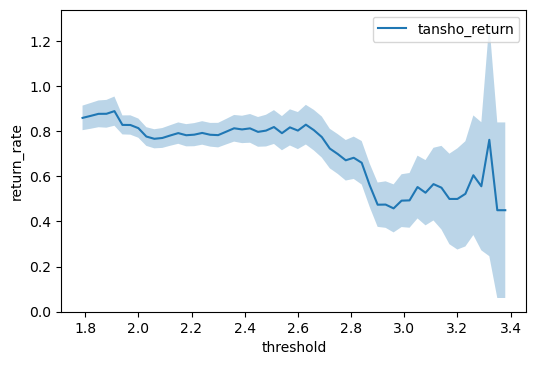

In [50]:
train2, test2 = split_data(r.data_c)
X_train2 = train2.drop(["rank","date"],axis=1).copy()
y_train2 = train2["rank"]

return_ = gain(me.tansho_return,X_train2)
plt.figure(dpi=100)
plt.xlabel('threshold')
plt.ylabel('return_rate')
plt.fill_between(return_.index, y1 = (return_["return_rate"] - return_["std"]),
                                 y2 = (return_["return_rate"] + return_["std"]),alpha=0.3)
return_rate = plt.plot(return_.index, return_["return_rate"], label="tansho_return")
plt.legend()

# ranking

In [73]:
train_query = train.groupby(level=0)['馬番'].count()
test_query = test.groupby(level=0)['馬番'].count()

params = {
 'objective': 'lambdarank',
 'metrics': "ndcg",
 "ndcg_eval_at" : [1,3,5],
 "boosting_type" : "gbdt",
}

#model = lgb.train(params, train_query, valid_sets=test_query)

In [75]:
train_q = [train_query[i] for i in range(len(train_query))]
test_q = [test_query[i] for i in range(len(test_query))]

params = {
 'objective': 'lambdarank',
 'metrics': "ndcg",
 "ndcg_eval_at" : [1,3,5],
 "boosting_type" : "gbdt",
}

model = lgb.train(params, train_q, valid_sets=test_q)

TypeError: Training only accepts Dataset object

In [98]:
dtrain = lgb.Dataset(train.drop('date', axis=1), group=train_query)
dval = lgb.Dataset(test.drop('date', axis=1), reference=dtrain, group=test_query)
moodel = lgb.train(params, dtrain, valid_sets=dval)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54594
[LightGBM] [Info] Number of data points in the train set: 23419, number of used features: 172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1	valid_0's ndcg@5: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3]	valid_0's ndcg@1: 1	valid_0's ndcg@3:

In [109]:
pred = moodel.predict(test.drop('date',axis=1), num_iteration=moodel.best_iteration)

In [115]:
pred.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

# regression

In [605]:
from pycaret.regression import *
import sklearn.ensemble as ske
rf = ske.RandomForestRegressor()
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
import optuna
from sklearn.model_selection import cross_val_score

In [614]:
# gridserch用のparams
parameters = {
    "n_estimators" : [10,20,30,50,100],
    "max_features" : ('sqrt', 'log2','auto', None),
    "max_depth" : (10,20,30,40,50,None),
    }

In [ ]:
ClassifierではlightGBM(ブースティング手法)を利用して分析を行なった。
RegressorではRandom Forest regressor(バギング手法)を利用して分析を行う。

In [422]:

r = Results(results_all)
r.preprocessing(regression=True) 
#columnにタイム(走破時間を秒数に直したものとタイムをrootとlogをとったものを追加)
hr = Horse_Results.read_pickle(["horse_results_19.pickle",
                   'horse_results_20.pickle',
                   'horse_results_21.pickle'])
r.merge_horse_results(hr)
P = Peds(n_peds_all2)
P.encode()
r.merge_peds(P.peds_e)
r.process_categorical()

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [283]:
#使用していない
train, test = split_data(r.data_p)
X = r.data_c.drop(["date","rank"], axis=1)
y = r.data_c["rls"]

In [423]:
#regressionで使用するX,y
X = r.data_p.dropna(axis=1).drop(["rls","rank","second","着順","単勝"],axis=1)
y = r.data_p["rls"]

In [378]:
#現在の特徴量
r.data_p.dropna()
#dropnaしたものに、horse_resultsをマージして、fillna = 0

,着順,枠番,馬番,斤量,単勝,course_len,weather,race_type,ground_state,date,...,jockey_id,rank,性,年齢,体重,体重変化,second,rls,開催,n_horses
201901010101,1,1,1,54.0,1.4,18.0,曇,芝,良,2019-07-27,...,05339,1,牡,2,518,-16,156.3,2.247616,01,9
201901010101,2,3,3,54.0,3.5,18.0,曇,芝,良,2019-07-27,...,05203,1,牡,2,496,-8,160.1,2.252953,01,9
201901010101,3,4,4,51.0,46.6,18.0,曇,芝,良,2019-07-27,...,01180,1,牡,2,546,6,160.9,2.254059,01,9
201901010101,4,8,9,51.0,56.8,18.0,曇,芝,良,2019-07-27,...,01179,0,牡,2,458,-8,162.5,2.256253,01,9
201901010101,5,5,5,54.0,140.3,18.0,曇,芝,良,2019-07-27,...,01062,0,牡,2,436,0,162.7,2.256526,01,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,12,6,11,56.0,120.3,26.0,曇,芝,重,2019-09-01,...,01165,0,セ,6,458,8,210.7,2.313101,10,16
201910021212,13,1,1,54.0,7.5,26.0,曇,芝,重,2019-09-01,...,01178,0,牡,5,460,2,212.0,2.314430,10,16
201910021212,14,2,3,54.0,99.2,26.0,曇,芝,重,2019-09-01,...,01176,0,牡,4,478,14,212.2,2.314634,10,16
201910021212,15,6,12,52.0,17.5,26.0,曇,芝,重,2019-09-01,...,00666,0,牝,3,468,2,212.2,2.314634,10,16


In [451]:
#特徴量を増やす
r.data_h.fillna(0)

,着順,枠番,馬番,斤量,単勝,course_len,weather,race_type,ground_state,date,...,first_to_rank_race_type_allR,first_to_final_race_type_allR,final_to_rank_race_type_allR,着順_開催_allR,賞金_開催_allR,着差_開催_allR,first_corner_開催_allR,first_to_rank_開催_allR,first_to_final_開催_allR,final_to_rank_開催_allR
201901010101,1,1,1,54.0,1.4,18.0,曇,芝,良,2019-07-27,...,5.000000,6.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201901010101,2,3,3,54.0,3.5,18.0,曇,芝,良,2019-07-27,...,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201901010101,3,4,4,51.0,46.6,18.0,曇,芝,良,2019-07-27,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201901010101,4,8,9,51.0,56.8,18.0,曇,芝,良,2019-07-27,...,1.000000,-2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201901010101,5,5,5,54.0,140.3,18.0,曇,芝,良,2019-07-27,...,-5.000000,-2.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040412,5,5,5,57.0,15.4,18.0,晴,ダート,重,2019-10-13,...,-3.055556,0.055556,-3.111111,1.000000,1535.700000,0.000000,3.000000,2.000000,0.000000,2.000000
201908040412,6,2,2,57.0,36.0,18.0,晴,ダート,重,2019-10-13,...,1.536585,0.170732,1.365854,6.750000,165.093750,1.081250,6.187500,-0.562500,0.250000,-0.812500
201908040412,7,1,1,57.0,7.2,18.0,晴,ダート,重,2019-10-13,...,2.500000,1.722222,0.777778,2.555556,438.311111,0.366667,5.111111,2.555556,1.444444,1.111111
201908040412,8,4,4,55.0,23.9,18.0,晴,ダート,重,2019-10-13,...,-3.000000,-0.333333,-2.666667,4.666667,267.075000,0.625000,2.416667,-2.250000,0.333333,-2.583333


In [ ]:
'course_len', 'weather', 'race_type',
       'ground_state', 'date', 'horse_id', 
    'jockey_id', 'rank', '性', '年齢',
     '開催'

In [424]:
#r.data_pの特徴量をカテゴリ変数に変換する
#引数にはregressorをTrueして制作した訓練データXを入力
def categorical(X):
    df = X.copy()
    
    weathers = df['weather'].unique()
    race_types = df['race_type'].unique()
    ground_states = df['ground_state'].unique()
    sexes = df['性'].unique()
    df['weather'] = pd.Categorical(df['weather'], weathers)
    df['race_type'] = pd.Categorical(df['race_type'], race_types)
    df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
    df['性'] = pd.Categorical(df['性'], sexes)
    df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])

    return df

In [546]:
#特徴量をカテゴリ変数かした学習データ
n_X = categorical(X)
n_X

,枠番,馬番,斤量,horse_id,jockey_id,年齢,体重,体重変化,開催,n_horses,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201901010101,1,1,54.0,2017105318,05339,2,518,-16,01,9,...,1,0,0,1,0,0,0,1,0,0
201901010101,3,3,54.0,2017104612,05203,2,496,-8,01,9,...,1,0,0,1,0,0,0,1,0,0
201901010101,4,4,51.0,2017103879,01180,2,546,6,01,9,...,1,0,0,1,0,0,0,1,0,0
201901010101,8,9,51.0,2017106259,01179,2,458,-8,01,9,...,1,0,0,1,0,0,0,1,0,0
201901010101,5,5,54.0,2017104140,01062,2,436,0,01,9,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202110040812,2,2,51.0,2018102912,01186,3,502,8,10,11,...,1,0,0,1,0,0,0,1,0,0
202110040812,7,9,57.0,2017100368,00732,4,464,0,10,11,...,1,0,0,1,0,0,0,1,0,0
202110040812,7,8,53.0,2018104097,01168,3,502,-10,10,11,...,1,0,0,1,0,0,0,1,0,0
202110040812,8,10,57.0,2016105133,01115,5,436,2,10,11,...,1,0,0,1,0,0,0,0,0,1


In [ ]:
 def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        #ラベルエンコーディング　horse_id,jockey_idを0始まりの整数に変換
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        df["horse_id"] = df["horse_id"].astype('category')
        df["jockey_id"] = df["jockey_id"].astype('category')
        
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        #race_idを軸に馬番をsort
        df = df.reset_index().sort_values(["index","馬番"]).set_index('index')
        df.index.name = None
        
        self.data_c = df

In [563]:
X_train, X_test, y_train, y_test = train_test_split(
n_X, y, test_size=0.2, random_state=100)

In [564]:
X_test

,枠番,馬番,斤量,horse_id,jockey_id,年齢,体重,体重変化,開催,n_horses,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
202110040610,7,14,52.0,2017100415,01174,4,450,4,10,16,...,0,1,0,1,0,0,0,0,1,0
202008020512,2,3,57.0,2014100750,01124,6,444,-6,08,15,...,0,1,0,0,0,1,0,1,0,0
202107050710,1,1,55.0,2017104055,01186,4,506,2,07,16,...,0,1,0,0,1,0,0,1,0,0
202105040212,5,9,57.0,2017105170,01127,4,536,0,05,16,...,0,1,0,1,0,0,0,1,0,0
202110010401,7,9,55.0,2018109176,01168,3,446,-6,10,11,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040302,4,4,54.0,2017106172,01126,2,396,-4,08,11,...,1,0,0,0,1,0,0,0,1,0
201904010407,7,9,52.0,2015103670,01177,4,490,8,04,11,...,0,1,0,1,0,0,0,0,1,0
202106010104,5,8,56.0,2017104947,01122,4,510,6,06,15,...,0,1,0,1,0,0,0,1,0,0
202008040205,8,14,51.0,2018106462,01182,2,470,0,08,14,...,1,0,0,0,0,1,0,0,1,0


In [572]:
#正答データ
r.data_p[["rls"]]

,rls
201901010101,2.247616
201901010101,2.252953
201901010101,2.254059
201901010101,2.256253
201901010101,2.256526
...,...
202110040812,2.306105
202110040812,2.306317
202110040812,2.306317
202110040812,2.306530


In [565]:
rf_r = rf.fit(X_train, y_train)

In [573]:
#r^2score
rf_r.predict(X_test)
rf_r.score(X_test,y_test)
score_ = rf_r.score(X_test,y_test)

0.4420966013949088

In [600]:
#adjusted2関数
#左からr2スコア、検証結果、特徴量数を入力
def adj_r2_score(r2_score,y_test,p=X_test.shape[1] -1):
    return 1-(1-score_)*\
    ((len(y_test)-1)/(len(y_test) - p -1))

In [603]:
adj_r2_score(score_,y_test,X_test.shape[1] -1)

0.4415620268303031

In [458]:
rf_i = rf_r.feature_importances_

print('Feature Importances:')

for i, feat in enumerate(n_X.columns):
    print('\t{0:10s} : {1:>.6f}'.format(feat, rf_i[i]))


Feature Importances:
	枠番         : 0.024367
	馬番         : 0.045676
	斤量         : 0.032853
	horse_id   : 0.137933
	jockey_id  : 0.092183
	年齢         : 0.040562
	体重         : 0.099305
	体重変化       : 0.065208
	開催         : 0.118571
	n_horses   : 0.087101
	weather_曇  : 0.013799
	weather_晴  : 0.013467
	weather_雨  : 0.007499
	weather_小雨 : 0.008982
	weather_小雪 : 0.000072
	weather_雪  : 0.000282
	race_type_芝 : 0.016256
	race_type_ダート : 0.016013
	race_type_障害 : 0.117385
	ground_state_良 : 0.012563
	ground_state_不良 : 0.006891
	ground_state_稍重 : 0.012082
	ground_state_重 : 0.009171
	性_牡        : 0.002695
	性_牝        : 0.016788
	性_セ        : 0.002295


In [608]:
model = RandomForestRegressor()

In [616]:
gridsearch = GridSearchCV(estimator=model,
                         param_grid=parameters,
                         scoring="accuracy")

In [617]:
gridsearch.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             n_jobs=None,
      

In [459]:
predicted = rf_r.predict(X_test)
rf_r.score(X_test, y_test)

0.4475777806356849

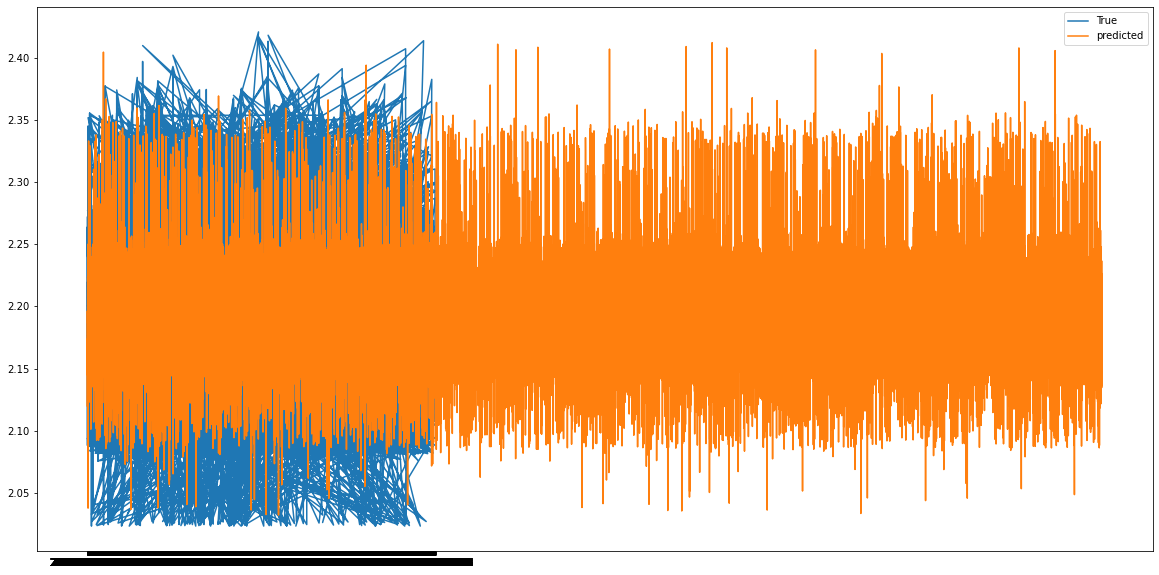

In [604]:
plt.figure(figsize=(20,10))
plt.plot(y_test,label="True")
plt.plot(predicted, label="predicted")
plt.legend()

In [466]:
#parames 最適化

In [480]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['mae'])
    bootstrap = trial.suggest_categorical('bootstrap',['True'])
    max_depth = trial.suggest_int('max_depth', 1, 100)
    max_features = trial.suggest_categorical('max_features', ['auto'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1,100)
    n_estimators =  trial.suggest_int('n_estimators', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split',2,5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)
    
    regr = RandomForestRegressor(bootstrap = bootstrap, criterion = criterion,
                                 max_depth = max_depth, max_features = max_features,
                                 max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,
                                 min_samples_split = min_samples_split,min_samples_leaf = min_samples_leaf,
                                 n_jobs=2)
    
    score = cross_val_score(regr, X_train, y_train, cv=5, scoring="r2")
    r2_mean = score.mean()
    print(r2_mean)

    return r2_mean


In [481]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)


[I 2022-01-15 06:31:12,814] A new study created in memory with name: no-name-0083c376-02d7-4b18-9b0b-a8aa616507eb


KeyboardInterrupt: 

In [144]:
sample = pd.DataFrame(r.data_h.index.unique())
samples = sample.sample(100)[0]

In [210]:
data_s = r.data_h.loc[samples]

In [152]:
regression_model = setup(data_s, target='rls', fold_shuffle=True,
            ignore_features=["着順","rank","単勝","second"], 
            categorical_features=["jockey_id","horse_id"],
            numeric_features=["枠番","馬番","斤量","n_horses"])

,Description,Value
0,session_id,1104
1,Target,rls
2,Original Data,"(1359, 104)"
3,Missing Values,True
4,Numeric Features,91
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(951, 558)"


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [158]:
tune = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0186,0.0005,0.0220,0.8597,0.0068,0.0084
1,0.0223,0.0006,0.0252,0.8187,0.0078,0.0100
2,0.0185,0.0006,0.0247,0.8720,0.0077,0.0084
3,0.0183,0.0005,0.0220,0.8833,0.0068,0.0082
4,0.0186,0.0005,0.0215,0.8884,0.0066,0.0084
5,0.0206,0.0006,0.0243,0.8357,0.0075,0.0092
6,0.0183,0.0004,0.0209,0.8870,0.0065,0.0083
7,0.0209,0.0008,0.0276,0.7980,0.0086,0.0094
8,0.0214,0.0006,0.0244,0.8430,0.0075,0.0096
9,0.0178,0.0005,0.0212,0.8981,0.0066,0.0080


In [ ]:
random forest regressorで回帰を行う　目的変数はroot log second
学習モデルを学習させる　パラメータを取得
テストデータで確認　race_idごとにレースタイム予測値を出力　
レースタイムの少ない順に1,2,3をわりふり、賭ける

直近　rbgtの実装を行い、各レースのレースタイムを出力、プロット

In [328]:
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [304]:
X

,着順,枠番,馬番,斤量,単勝,course_len,horse_id,jockey_id,rank,年齢,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201901010101,1,1,1,54.0,1.4,18.0,10614,152,1,2,...,1,0,0,1,0,0,0,1,0,0
201901010101,7,2,2,54.0,114.7,18.0,8270,73,0,2,...,1,0,0,1,0,0,0,0,1,0
201901010101,2,3,3,54.0,3.5,18.0,10194,142,1,2,...,1,0,0,1,0,0,0,1,0,0
201901010101,3,4,4,51.0,46.6,18.0,9851,136,1,2,...,1,0,0,1,0,0,0,1,0,0
201901010101,5,5,5,54.0,140.3,18.0,9967,47,0,2,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,15,6,12,52.0,17.5,26.0,6372,5,0,3,...,1,0,0,0,0,0,1,0,1,0
201910021212,5,7,13,57.0,7.7,26.0,3782,28,0,4,...,1,0,0,0,0,0,1,1,0,0
201910021212,1,7,14,57.0,4.4,26.0,3136,77,1,4,...,1,0,0,0,0,0,1,1,0,0
201910021212,3,8,15,57.0,21.9,26.0,3495,87,1,4,...,1,0,0,0,0,0,1,1,0,0


In [295]:
ind = np.argsort(rf.feature_importances_)[::-1]
imp = rf.feature_importances_[ind]

In [247]:
X.isnull().sum().value_counts()

0        92
4803     11
27391     7
7713      7
16179     7
24007     7
18378     7
8520      5
19101     5
8227      5
21296     5
4805      5
4804      5
8517      2
19097     2
8226      2
21289     2
dtype: int64

In [ ]:
X

In [261]:
[X.columns[i] for i in range(len(X.columns))]

['着順',
 '枠番',
 '馬番',
 '斤量',
 '単勝',
 'course_len',
 'horse_id',
 'jockey_id',
 '年齢',
 '体重',
 '体重変化',
 'second',
 'rls',
 'n_horses',
 '着順_5R',
 '賞金_5R',
 '着差_5R',
 'first_corner_5R',
 'first_to_rank_5R',
 'first_to_final_5R',
 'final_to_rank_5R',
 '着順_course_len_5R',
 '賞金_course_len_5R',
 '着差_course_len_5R',
 'first_corner_course_len_5R',
 'first_to_rank_course_len_5R',
 'first_to_final_course_len_5R',
 'final_to_rank_course_len_5R',
 '着順_race_type_5R',
 '賞金_race_type_5R',
 '着差_race_type_5R',
 'first_corner_race_type_5R',
 'first_to_rank_race_type_5R',
 'first_to_final_race_type_5R',
 'final_to_rank_race_type_5R',
 '着順_開催_5R',
 '賞金_開催_5R',
 '着差_開催_5R',
 'first_corner_開催_5R',
 'first_to_rank_開催_5R',
 'first_to_final_開催_5R',
 'final_to_rank_開催_5R',
 '着順_9R',
 '賞金_9R',
 '着差_9R',
 'first_corner_9R',
 'first_to_rank_9R',
 'first_to_final_9R',
 'final_to_rank_9R',
 '着順_course_len_9R',
 '賞金_course_len_9R',
 '着差_course_len_9R',
 'first_corner_course_len_9R',
 'first_to_rank_course_len_9R',
 'fi

In [259]:
[X.isnull().any(axis=0)[i] for i in range(len(X.columns))]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fal

In [264]:
X.fillna(0)

,着順,枠番,馬番,斤量,単勝,course_len,horse_id,jockey_id,年齢,体重,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201901010101,1,1,1,54.0,1.4,18.0,10614,152,2,518,...,1,0,0,1,0,0,0,1,0,0
201901010101,7,2,2,54.0,114.7,18.0,8270,73,2,450,...,1,0,0,1,0,0,0,0,1,0
201901010101,2,3,3,54.0,3.5,18.0,10194,142,2,496,...,1,0,0,1,0,0,0,1,0,0
201901010101,3,4,4,51.0,46.6,18.0,9851,136,2,546,...,1,0,0,1,0,0,0,1,0,0
201901010101,5,5,5,54.0,140.3,18.0,9967,47,2,436,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,15,6,12,52.0,17.5,26.0,6372,5,3,468,...,1,0,0,0,0,0,1,0,1,0
201910021212,5,7,13,57.0,7.7,26.0,3782,28,4,486,...,1,0,0,0,0,0,1,1,0,0
201910021212,1,7,14,57.0,4.4,26.0,3136,77,4,484,...,1,0,0,0,0,0,1,1,0,0
201910021212,3,8,15,57.0,21.9,26.0,3495,87,4,504,...,1,0,0,0,0,0,1,1,0,0


In [266]:
X#.shape()

,着順,枠番,馬番,斤量,単勝,course_len,horse_id,jockey_id,年齢,体重,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_不良,ground_state_稍重,ground_state_重,性_牡,性_牝,性_セ
201901010101,1,1,1,54.0,1.4,18.0,10614,152,2,518,...,1,0,0,1,0,0,0,1,0,0
201901010101,7,2,2,54.0,114.7,18.0,8270,73,2,450,...,1,0,0,1,0,0,0,0,1,0
201901010101,2,3,3,54.0,3.5,18.0,10194,142,2,496,...,1,0,0,1,0,0,0,1,0,0
201901010101,3,4,4,51.0,46.6,18.0,9851,136,2,546,...,1,0,0,1,0,0,0,1,0,0
201901010101,5,5,5,54.0,140.3,18.0,9967,47,2,436,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,15,6,12,52.0,17.5,26.0,6372,5,3,468,...,1,0,0,0,0,0,1,0,1,0
201910021212,5,7,13,57.0,7.7,26.0,3782,28,4,486,...,1,0,0,0,0,0,1,1,0,0
201910021212,1,7,14,57.0,4.4,26.0,3136,77,4,484,...,1,0,0,0,0,0,1,1,0,0
201910021212,3,8,15,57.0,21.9,26.0,3495,87,4,504,...,1,0,0,0,0,0,1,1,0,0


In [269]:
X.shape

(47118, 176)

In [270]:
X.dropna().shape

(14103, 176)

In [178]:
[r.data_c.columns[i] for i in range(len(r.data_c.columns))]

['着順',
 '枠番',
 '馬番',
 '斤量',
 '単勝',
 'course_len',
 'date',
 'horse_id',
 'jockey_id',
 'rank',
 '年齢',
 '体重',
 '体重変化',
 'second',
 'rls',
 'n_horses',
 '着順_5R',
 '賞金_5R',
 '着差_5R',
 'first_corner_5R',
 'first_to_rank_5R',
 'first_to_final_5R',
 'final_to_rank_5R',
 '着順_course_len_5R',
 '賞金_course_len_5R',
 '着差_course_len_5R',
 'first_corner_course_len_5R',
 'first_to_rank_course_len_5R',
 'first_to_final_course_len_5R',
 'final_to_rank_course_len_5R',
 '着順_race_type_5R',
 '賞金_race_type_5R',
 '着差_race_type_5R',
 'first_corner_race_type_5R',
 'first_to_rank_race_type_5R',
 'first_to_final_race_type_5R',
 'final_to_rank_race_type_5R',
 '着順_開催_5R',
 '賞金_開催_5R',
 '着差_開催_5R',
 'first_corner_開催_5R',
 'first_to_rank_開催_5R',
 'first_to_final_開催_5R',
 'final_to_rank_開催_5R',
 '着順_9R',
 '賞金_9R',
 '着差_9R',
 'first_corner_9R',
 'first_to_rank_9R',
 'first_to_final_9R',
 'final_to_rank_9R',
 '着順_course_len_9R',
 '賞金_course_len_9R',
 '着差_course_len_9R',
 'first_corner_course_len_9R',
 'first_to_rank_co

In [278]:
X.dropna()

,着順,枠番,馬番,斤量,単勝,course_len,weather,race_type,ground_state,horse_id,jockey_id,性,年齢,体重,体重変化,second,rls,開催,n_horses
201901010101,1,1,1,54.0,1.4,18.0,曇,芝,良,2017105318,05339,牡,2,518,-16,156.3,2.247616,01,9
201901010101,2,3,3,54.0,3.5,18.0,曇,芝,良,2017104612,05203,牡,2,496,-8,160.1,2.252953,01,9
201901010101,3,4,4,51.0,46.6,18.0,曇,芝,良,2017103879,01180,牡,2,546,6,160.9,2.254059,01,9
201901010101,4,8,9,51.0,56.8,18.0,曇,芝,良,2017106259,01179,牡,2,458,-8,162.5,2.256253,01,9
201901010101,5,5,5,54.0,140.3,18.0,曇,芝,良,2017104140,01062,牡,2,436,0,162.7,2.256526,01,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,12,6,11,56.0,120.3,26.0,曇,芝,重,2013104167,01165,セ,6,458,8,210.7,2.313101,10,16
201910021212,13,1,1,54.0,7.5,26.0,曇,芝,重,2014105643,01178,牡,5,460,2,212.0,2.314430,10,16
201910021212,14,2,3,54.0,99.2,26.0,曇,芝,重,2015102081,01176,牡,4,478,14,212.2,2.314634,10,16
201910021212,15,6,12,52.0,17.5,26.0,曇,芝,重,2016104221,00666,牝,3,468,2,212.2,2.314634,10,16


In [310]:
r.data_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130582 entries, 201901010101 to 202110040812
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   着順            130582 non-null  int64         
 1   枠番            130582 non-null  int64         
 2   馬番            130582 non-null  int64         
 3   斤量            130582 non-null  float64       
 4   単勝            130582 non-null  float64       
 5   course_len    47118 non-null   float64       
 6   weather       130582 non-null  object        
 7   race_type     130582 non-null  object        
 8   ground_state  130582 non-null  object        
 9   date          47118 non-null   datetime64[ns]
 10  horse_id      130582 non-null  object        
 11  jockey_id     130582 non-null  object        
 12  rank          130582 non-null  int64         
 13  性             130582 non-null  object        
 14  年齢            130582 non-null  int64         
 15  体重   

In [320]:
X = r.data_c.fillna(0).drop(["date"],axis=1)
y = r.data_c["rls"]

In [321]:
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [326]:
np.argsort(rf.feature_importances_)

166